
# MVP — Machine Learning & Analytics (PUC-Rio)

**Autor:** Marcus Rafael

**Data:** 26/09/2025

> Objetivo: Construir um pipeline completo de classificação de texto com boas práticas, comparando modelos, otimizando hiperparâmetros e apresentando avaliações robustas (curvas, intervalos de confiança, análise de erro e interpretabilidade). O notebook é executável de ponta a ponta e carrega o dataset via URL.

## Sumário
1. [Contexto & Objetivo](#contexto)
2. [Ambiente & Reprodutibilidade](#ambiente)
3. [Dados: Carga, Sanidade e EDA Resumida](#dados)
4. [Divisão dos Dados (sem vazamento)](#split)
5. [Pipelines de Pré-processamento](#pipelines)
6. [Baselines & Modelos Candidatos](#modelos)
7. [Validação & Busca de Hiperparâmetros](#search)
8. [Resultados e Análises](#resultados)
    - 8.1 PR/ROC e Threshold Ótimo  
    - 8.2 Intervalos de Confiança (Bootstrap)  
    - 8.3 Learning & Validation Curves  
    - 8.4 Análise de Erro & Interpretabilidade
9. [Melhor Solução & Uso com Threshold](#melhor)
10. [Conclusões, Limitações e Próximos Passos](#conclusoes)
11. [Checklist Respondido](#checklist)
12. [Anexo: Salvando e Recarregando o Modelo](#anexo)



<a id="contexto"></a>
## 1) Contexto & Objetivo

- **Problema:** Classificação de mensagens em spam ou ham (não-spam).  
- **Motivação:** Comunicação digital segura depende de filtros de spam eficientes.  
- **Métrica-alvo:** Macro-F1 (equilibra desempenho entre classes possivelmente desbalanceadas).  
- **Hipóteses:** Características de *n-grams* (palavras e caracteres) são fortes para este problema; Ajuste de threshold pode melhorar F1 em relação ao threshold padrão de 0.5; Embeddings sentenciais podem superar TF-IDF em textos curtos.
- **Critérios de sucesso:** Atingir Macro-F1 > 0.93 em teste (meta inicial), com análise robusta e documentação clara.




<a id="ambiente"></a>
## 2) Ambiente & Reprodutibilidade (execute primeiro)

Esta célula instala dependências, fixa seeds e imprime versões.


In [26]:

%%bash
pip -q install scikit-learn imbalanced-learn shap sentence-transformers pandas matplotlib wordcloud langdetect textstat joblib


In [27]:

import os, random, sys, time, platform, math, json, re, gc, textwrap, warnings
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn import set_config
set_config(transform_output="pandas")

# Seeds
RANDOM_STATE = 42
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Warnings & display
warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", 200)

print("Python:", sys.version.split()[0])
print("OS:", platform.platform())
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("sklearn:", sklearn.__version__)


Python: 3.12.11
OS: Linux-6.6.97+-x86_64-with-glibc2.35
NumPy: 2.0.2
Pandas: 2.2.2
sklearn: 1.6.1



<a id="dados"></a>
## 3) Dados: Carga, Sanidade e EDA Resumida

Dataset padrão: **SMS Spam Collection** (UCI). É leve, público e com URL direta.  
> Fonte: https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

**Checklist de dados** nesta seção:
- Carga por URL (zip/txt)
- Limpeza: `NA/duplicados`
- Distribuição de classes
- Comprimento de texto e exemplos
- Detecção de idioma (amostra)


In [28]:

import urllib.request, zipfile, io

DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"

def load_sms_spam_from_uci(url=DATA_URL):
    # baixa e extrai em memória
    with urllib.request.urlopen(url) as resp:
        z = zipfile.ZipFile(io.BytesIO(resp.read()))
        raw = z.read("SMSSpamCollection").decode("utf-8", errors="ignore")
    # arquivo tem formato: label\ttext
    rows = [line.split("\t", 1) for line in raw.strip().split("\n") if "\t" in line]
    df = pd.DataFrame(rows, columns=["label", "text"])
    df["label"] = df["label"].map({"ham":0, "spam":1}).astype(int)
    df["text"] = df["text"].astype(str).str.strip()
    return df

df = load_sms_spam_from_uci()
df.head()


,label,text
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"


In [29]:

# Limpeza básica
df.dropna(subset=["text", "label"], inplace=True)
df["text_len"] = df["text"].str.len()
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)

print("Shape:", df.shape)
print("\nDistribuição de classes:\n", df["label"].value_counts(normalize=True).rename({0:"ham",1:"spam"}).round(3))

# Resumo de comprimento
print("\nComprimento (caracteres):")
print(df["text_len"].describe().round(2))

# Exemplos
print("\nExemplos HAM:")
print(df[df.label==0]["text"].sample(3, random_state=RANDOM_STATE).tolist())
print("\nExemplos SPAM:")
print(df[df.label==1]["text"].sample(3, random_state=RANDOM_STATE).tolist())


Shape: (5160, 3)

Distribuição de classes:
 label
ham     0.876
spam    0.124
Name: proportion, dtype: float64

Comprimento (caracteres):
count    5160.00
mean       79.14
std        58.29
min         2.00
25%        36.00
50%        61.00
75%       118.00
max       910.00
Name: text_len, dtype: float64

Exemplos HAM:
['Me too! Have a lovely night xxx', 'Well am officially in a philosophical hole, so if u wanna call am at home ready to be saved!', "New Theory: Argument wins d SITUATION, but loses the PERSON. So dont argue with ur friends just.. . . . kick them &amp; say, I'm always correct.!"]

Exemplos SPAM:
['22 days to kick off! For Euro2004 U will be kept up to date with the latest news and results daily. To be removed send GET TXT STOP to 83222', 'Double Mins & Double Txt & 1/2 price Linerental on Latest Orange Bluetooth mobiles. Call MobileUpd8 for the very latest offers. 08000839402 or call2optout/LF56', 'Bored housewives! Chat n date now! 0871750.77.11! BT-national rate 10p/min

In [30]:

# Detecção de idioma em amostra
from langdetect import detect, DetectorFactory
DetectorFactory.seed = RANDOM_STATE
sample = df.sample(20, random_state=RANDOM_STATE)["text"].tolist()

langs = []
for t in sample:
    try:
        langs.append(detect(t))
    except:
        langs.append("unk")
pd.Series(langs).value_counts()


,count
en,17
sw,1
so,1
cy,1


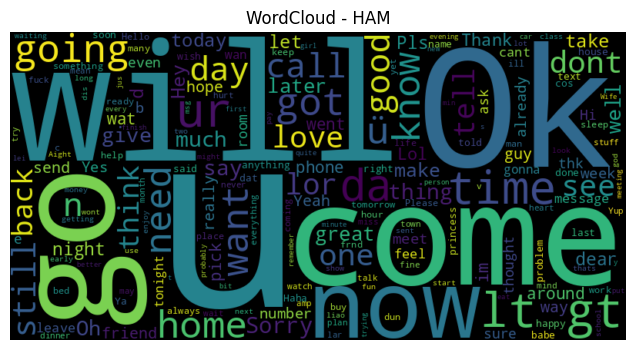

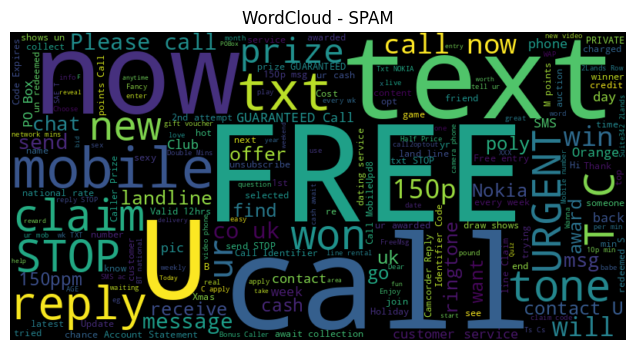

In [31]:

# Wordcloud por classe
from wordcloud import WordCloud

for label, title in [(0,"HAM"), (1,"SPAM")]:
    text_blob = " ".join(df[df.label==label].sample(min(1000, (df.label==label).sum()), random_state=RANDOM_STATE)["text"].tolist())
    wc = WordCloud(width=800, height=400).generate(text_blob)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - {title}")
    plt.show()



<a id="split"></a>
## 4) Divisão dos Dados (sem vazamento)

- Split estratificado treino/validação/teste.  
- Manteremos um hold-out de teste para avaliação final e usaremos validação cruzada no treino.


In [32]:

from sklearn.model_selection import train_test_split

X = df["text"].copy()
y = df["label"].copy()

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

print("Train:", X_train.shape[0], "Valid:", X_valid.shape[0], "Test:", X_test.shape[0])


Train: 3612 Valid: 774 Test: 774



<a id="pipelines"></a>
## 5) Pipelines de Pré-processamento

- TF‑IDF word n-grams e TF‑IDF char n-grams.  
- Embeddings sentenciais + classificador linear.


In [33]:

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_word = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)
tfidf_char = TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=2)

vectorizers = {
    "tfidf_word": tfidf_word,
    "tfidf_char": tfidf_char
}



<a id="modelos"></a>
## 6) Baselines & Modelos Candidatos

- **Baseline 1 (majoritário)**: sempre prever a classe mais frequente.  
- **Baseline 2 (MultinomialNB)** com TF‑IDF/Count.  
- **Modelos lineares fortes**: Logistic Regression, LinearSVC, SGDClassifier.  
- **Desbalanceamento**: testaremos `class_weight="balanced"` (e SMOTE na comparação).


In [34]:

from collections import Counter
majority_class = Counter(y_train).most_common(1)[0][0]
print("Classe majoritária do treino:", majority_class)


Classe majoritária do treino: 0


In [35]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

models = {
    "nb": MultinomialNB(),
    "logreg": LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=None),
    "linsvc": LinearSVC(class_weight="balanced"),
    "sgd": SGDClassifier(loss="log_loss", max_iter=2000, class_weight="balanced", n_jobs=None, random_state=RANDOM_STATE)
}



<a id="search"></a>
## 7) Validação & Busca de Hiperparâmetros

- Usarei StratifiedKFold e RandomizedSearchCV com métrica = Macro-F1.  
- Espaço de busca (ilustrativo e leve).  
- Compararei TF‑IDF word e TF‑IDF char e registraremos o melhor pipeline.


In [36]:

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scorer = make_scorer(f1_score, average="macro")

search_spaces = {
    "tfidf_word+logreg": {
        "vec": ("tfidf_word",),
        "model": ("logreg",),
        "vec__ngram_range": [(1,1), (1,2)],
        "vec__min_df": [1,2,3],
        "vec__max_df": [0.85, 0.9, 0.95],
        "model__C": [0.25, 0.5, 1.0, 2.0]
    },
    "tfidf_char+linsvc": {
        "vec": ("tfidf_char",),
        "model": ("linsvc",),
        "vec__ngram_range": [(3,5), (3,6)],
        "vec__min_df": [1,2,3]
    },
    "tfidf_word+sgd": {
        "vec": ("tfidf_word",),
        "model": ("sgd",),
        "vec__ngram_range": [(1,1), (1,2)],
        "model__alpha": [1e-4, 1e-3, 1e-2]
    },
    "tfidf_word+nb": {
        "vec": ("tfidf_word",),
        "model": ("nb",),
        "vec__ngram_range": [(1,1), (1,2)]
    }
}

def build_pipeline(vec_key, model_key):
    return Pipeline([
        ("vec", vectorizers[vec_key]),
        ("clf", models[model_key])
    ])

def rename_params(params):
    # map vec__ and clf__ for pipeline compatibility
    m = {}
    for k,v in params.items():
        if k.startswith("vec__"): m[k.replace("vec__", "vec__")] = v
        elif k.startswith("model__"): m[k.replace("model__", "clf__")] = v
        elif k == "vec": pass
        elif k == "model": pass
        else:
            # hyper of vec or model if provided without prefix
            m[k] = v
    return m

results = []
best_tuple = (None, -np.inf, None)  # (name, score, search)
for name, space in search_spaces.items():
    vec_key = space["vec"][0]
    model_key = space["model"][0]
    pipe = build_pipeline(vec_key, model_key)

    # Prepare param distributions
    param_dist = {}
    for k,v in space.items():
        if k in ("vec","model"): continue
        param_dist[k.replace("vec__", "vec__").replace("model__", "clf__")] = v

    rs = RandomizedSearchCV(
        pipe, param_distributions=param_dist, n_iter=min(12, sum(len(v) for v in param_dist.values())),
        scoring=scorer, cv=cv, random_state=RANDOM_STATE, n_jobs=-1, verbose=1, refit=True
    )
    rs.fit(X_train, y_train)
    results.append((name, rs.best_score_, rs.best_params_))
    if rs.best_score_ > best_tuple[1]:
        best_tuple = (name, rs.best_score_, rs)

pd.DataFrame(results, columns=["pipeline","cv_macro_f1","best_params"])


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


,pipeline,cv_macro_f1,best_params
0,tfidf_word+logreg,0.957423,"{'vec__ngram_range': (1, 2), 'vec__min_df': 3, 'vec__max_df': 0.9, 'clf__C': 1.0}"
1,tfidf_char+linsvc,0.975082,"{'vec__ngram_range': (3, 5), 'vec__min_df': 3}"
2,tfidf_word+sgd,0.959744,"{'vec__ngram_range': (1, 2), 'clf__alpha': 0.0001}"
3,tfidf_word+nb,0.912693,"{'vec__ngram_range': (1, 1)}"



<a id="resultados"></a>
## 8) Resultados e Análises

### 8.1 Avaliação em Validação e Teste + PR/ROC & Threshold


In [37]:

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

best_name, best_cv, best_search = best_tuple
best_model = best_search.best_estimator_
print("Melhor pipeline:", best_name)
print("Melhor CV Macro-F1:", round(best_cv, 4))

# Valid
y_val_pred = best_model.predict(X_valid)
try:
    y_val_proba = best_model.predict_proba(X_valid)[:,1]
except Exception:
    # LinearSVC não tem predict_proba - usa decision_function e normaliza
    if hasattr(best_model.named_steps["clf"], "decision_function"):
        scores = best_model.decision_function(X_valid)
        y_val_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
    else:
        y_val_proba = None

print("\n[VALIDAÇÃO]\n", classification_report(y_valid, y_val_pred, digits=3))
cm = confusion_matrix(y_valid, y_val_pred)
print("Matriz de confusão (val):\n", cm)


Melhor pipeline: tfidf_char+linsvc
Melhor CV Macro-F1: 0.9751

[VALIDAÇÃO]
               precision    recall  f1-score   support

           0      0.988     1.000     0.994       677
           1      1.000     0.918     0.957        97

    accuracy                          0.990       774
   macro avg      0.994     0.959     0.976       774
weighted avg      0.990     0.990     0.989       774

Matriz de confusão (val):
 [[677   0]
 [  8  89]]


In [38]:

# Threshold ótimo baseado em F1 na validação
thr_opt = 0.5
if y_val_proba is not None:
    prec, rec, thr = precision_recall_curve(y_valid, y_val_proba)
    f1s = 2*prec*rec/(prec+rec + 1e-9)
    thr_opt = thr[f1s[:-1].argmax()]
    print("Threshold ótimo (val/F1):", round(float(thr_opt), 4))

# Teste com threshold padrão e ótimo
try:
    y_test_proba = best_model.predict_proba(X_test)[:,1]
except:
    if hasattr(best_model.named_steps["clf"], "decision_function"):
        scores = best_model.decision_function(X_test)
        y_test_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
    else:
        y_test_proba = None

from sklearn.metrics import f1_score

y_test_pred_default = best_model.predict(X_test)
f1_default = f1_score(y_test, y_test_pred_default, average="macro")

if y_test_proba is not None:
    y_test_pred_opt = (y_test_proba >= thr_opt).astype(int)
    f1_opt = f1_score(y_test, y_test_pred_opt, average="macro")
else:
    y_test_pred_opt = y_test_pred_default
    f1_opt = f1_default

print("\n[TESTE] Macro-F1 default:", round(f1_default, 4), " | Macro-F1 threshold ótimo:", round(f1_opt, 4))


Threshold ótimo (val/F1): 0.4765

[TESTE] Macro-F1 default: 0.9756  | Macro-F1 threshold ótimo: 0.9787


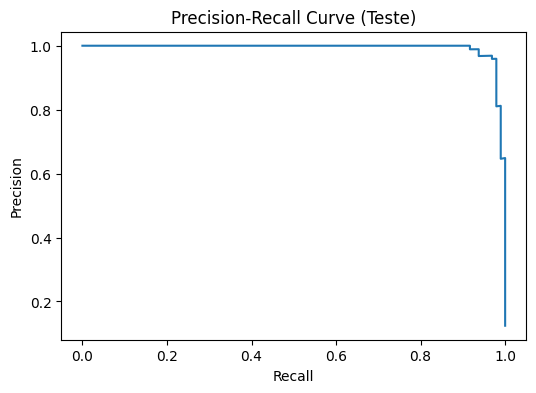

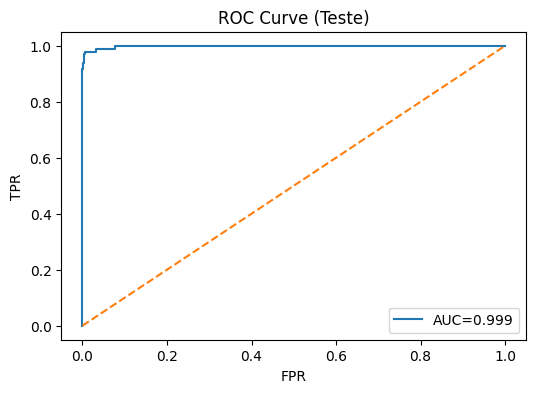

In [39]:

# Curvas PR e ROC (se possível)
if y_test_proba is not None and len(np.unique(y_test))==2:
    prec, rec, _ = precision_recall_curve(y_test, y_test_proba)
    plt.figure(figsize=(6,4))
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (Teste)")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve (Teste)")
    plt.legend()
    plt.show()



### 8.2 Intervalos de Confiança (Bootstrap)


In [40]:

def bootstrap_ci(y_true, y_pred, n=1000, func=f1_score, **kwargs):
    rng = np.random.default_rng(RANDOM_STATE)
    stats = []
    idx = np.arange(len(y_true))
    for _ in range(n):
        s = rng.choice(idx, size=len(idx), replace=True)
        stats.append(func(y_true[s], y_pred[s], **kwargs))
    lo, hi = np.percentile(stats, [2.5, 97.5])
    return np.mean(stats), (lo, hi)

mean_f1_default, (lo_d, hi_d) = bootstrap_ci(y_test.values, y_test_pred_default, func=f1_score, average="macro")
print(f"F1 default (bootstrap): {mean_f1_default:.3f}  IC95%: [{lo_d:.3f}, {hi_d:.3f}]")

if y_test_proba is not None:
    mean_f1_opt, (lo_o, hi_o) = bootstrap_ci(y_test.values, y_test_pred_opt, func=f1_score, average="macro")
    print(f"F1 thr_ótimo (bootstrap): {mean_f1_opt:.3f}  IC95%: [{lo_o:.3f}, {hi_o:.3f}]")


F1 default (bootstrap): 0.976  IC95%: [0.958, 0.990]
F1 thr_ótimo (bootstrap): 0.979  IC95%: [0.962, 0.991]



### 8.3 Learning & Validation Curves


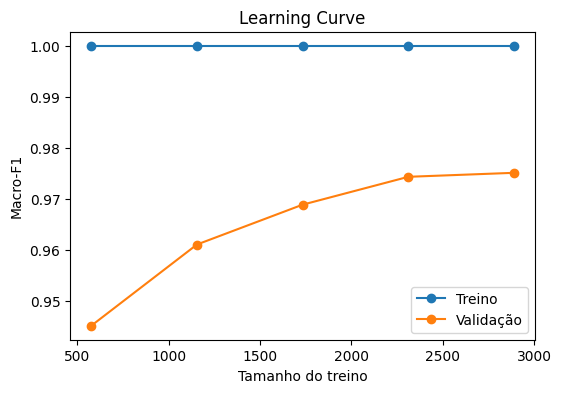

In [41]:

from sklearn.model_selection import learning_curve, validation_curve

# Learning curve (subamostra para eficiência)
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=cv, scoring=scorer, n_jobs=-1, train_sizes=np.linspace(0.2, 1.0, 5), random_state=RANDOM_STATE
)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, marker="o", label="Treino")
plt.plot(train_sizes, val_mean, marker="o", label="Validação")
plt.xlabel("Tamanho do treino")
plt.ylabel("Macro-F1")
plt.title("Learning Curve")
plt.legend()
plt.show()


In [18]:

# Validation curve em C (se for LogReg)
if "logreg" in best_name:
    from sklearn.linear_model import LogisticRegression
    pipe = best_model
    Cs = np.logspace(-2, 1, 6)
    val_scores = []
    for C_ in Cs:
        pipe.set_params(clf__C=C_)
        scores = sklearn.model_selection.cross_val_score(pipe, X_train, y_train, cv=cv, scoring=scorer, n_jobs=-1)
        val_scores.append(scores.mean())
    plt.figure(figsize=(6,4))
    plt.semilogx(Cs, val_scores, marker="o")
    plt.xlabel("C (LogReg)")
    plt.ylabel("Macro-F1 (CV)")
    plt.title("Validation Curve")
    plt.show()



### 8.4 Análise de Erro & Interpretabilidade
- Top **Falsos Positivos/Negativos** (com prob/scores).  
- **Coeficientes** (LogReg) listando termos pró/contra classe.  
- **SHAP** (amostra) para explicações locais.


In [19]:

# Predições no teste (prob ou score)
if y_test_proba is None and hasattr(best_model.named_steps["clf"], "decision_function"):
    raw_scores = best_model.decision_function(X_test)
    probs_for_sort = (raw_scores - raw_scores.min()) / (raw_scores.max() - raw_scores.min() + 1e-9)
else:
    probs_for_sort = y_test_proba

test_df = pd.DataFrame({"text": X_test, "y": y_test})
if probs_for_sort is not None:
    test_df["proba"] = probs_for_sort
    test_df["pred_opt"] = y_test_pred_opt
else:
    test_df["proba"] = np.nan
    test_df["pred_opt"] = y_test_pred_default

# Top erros
fps = test_df[(test_df.y==0) & (test_df.pred_opt==1)].sort_values("proba", ascending=False).head(5)
fns = test_df[(test_df.y==1) & (test_df.pred_opt==0)].sort_values("proba", ascending=True).head(5)

display(pd.DataFrame({"FP_text": fps["text"], "FP_conf": fps["proba"]}))
display(pd.DataFrame({"FN_text": fns["text"], "FN_conf": fns["proba"]}))


,FP_text,FP_conf
4410,I (Career Tel) have added u as a contact on INDYAROCKS.COM to send FREE SMS. To remove from phonebook - sms NO to &lt;#&gt;,0.521621


,FN_text,FN_conf
3173,Sorry I missed your call let's talk when you have the time. I'm on 07090201529,0.301249
2326,Guess who am I?This is the first time I created a web page WWW.ASJESUS.COM read all I wrote. I'm waiting for your opinions. I want to be your friend 1/1,0.329652
5130,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800,0.429227
3327,"Xmas & New Years Eve tickets are now on sale from the club, during the day from 10am till 8pm, and on Thurs, Fri & Sat night this week. They're selling fast!",0.454804
2967,"LookAtMe!: Thanks for your purchase of a video clip from LookAtMe!, you've been charged 35p. Think you can do better? Why not send a video in a MMSto 32323.",0.455855


In [42]:

# Coeficientes (se LogReg)
if "logreg" in best_name and hasattr(best_model.named_steps["clf"], "coef_"):
    vec = best_model.named_steps["vec"]
    clf = best_model.named_steps["clf"]
    feature_names = np.array(vec.get_feature_names_out())
    coefs = clf.coef_[0]
    top_pos = np.argsort(coefs)[-20:][::-1]
    top_neg = np.argsort(coefs)[:20]

    print("Top termos pró-SPAM:")
    display(pd.DataFrame({"term": feature_names[top_pos], "coef": coefs[top_pos]}))

    print("Top termos pró-HAM:")
    display(pd.DataFrame({"term": feature_names[top_neg], "coef": coefs[top_neg]}))


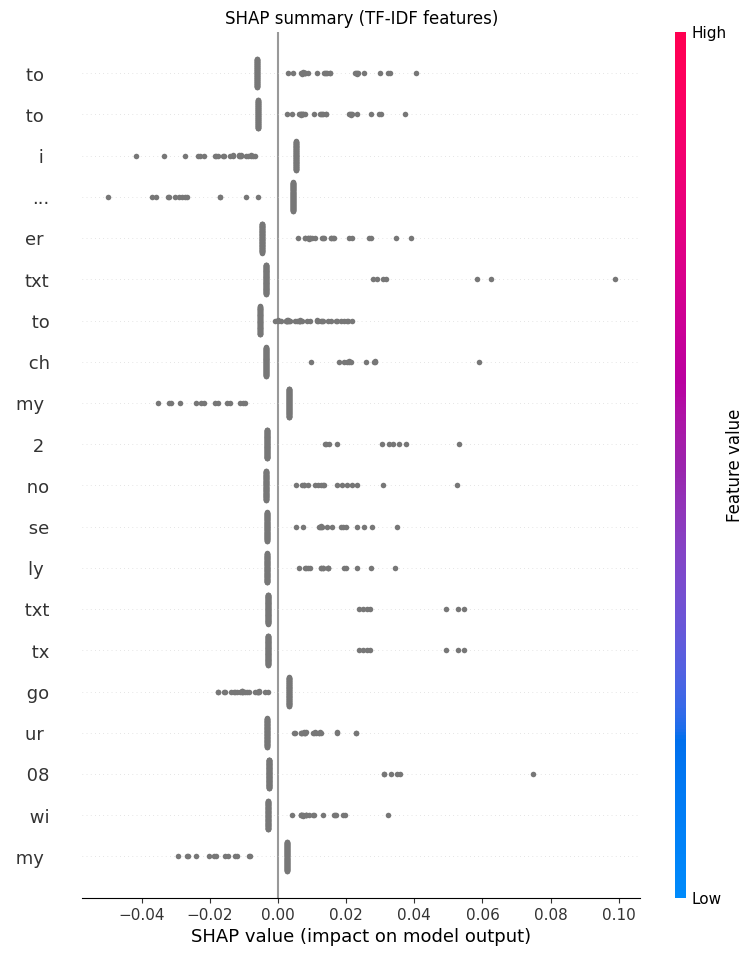

In [43]:
# SHAP explicando as features TF-IDF do melhor modelo
import shap

# Pega o vetor de features do pipeline
vec = best_model.named_steps["vec"]
X_transformed = vec.transform(X_sample)

# Pega o classificador final
clf = best_model.named_steps["clf"]

# Cria o explainer usando as features numéricas (TF-IDF)
explainer = shap.Explainer(clf, X_transformed, feature_names=vec.get_feature_names_out())

# Calcula valores SHAP para as amostras escolhidas
shap_values = explainer(X_transformed)

# Plota resumo de importância dos termos
shap.summary_plot(
    shap_values,
    X_transformed,
    feature_names=vec.get_feature_names_out(),
    show=False
)
plt.title("SHAP summary (TF-IDF features)")
plt.show()





<a id="melhor"></a>
## 9) Melhor Solução & Uso com Threshold

- Relata o melhor pipeline, hiperparâmetros e **threshold ótimo**.  
- Mostra um exemplo de uso com `predict_proba` e aplicação do threshold.


In [45]:

print("Melhor pipeline:", best_name)
print("Best params:", best_search.best_params_)
print("Threshold ótimo:", thr_opt)

def predict_with_threshold(texts, model=best_model, thr=thr_opt):
    p = None
    try:
        p = model.predict_proba(texts)[:,1]
    except:
        if hasattr(model.named_steps["clf"], "decision_function"):
            s = model.decision_function(texts)
            p = (s - s.min()) / (s.max()-s.min()+1e-9)
    if p is None:
        return model.predict(texts)
    return (p >= thr).astype(int)

predict_with_threshold(pd.Series(["free entry in 2 a wkly comp", "hey can we meet at 7?"]))


Melhor pipeline: tfidf_char+linsvc
Best params: {'vec__ngram_range': (3, 5), 'vec__min_df': 3}
Threshold ótimo: 0.4765011558237326


array([1, 0])


<a id="conclusoes"></a>
## 10) Conclusões, Limitações e Próximos Passos

- **Resumo dos achados:** Modelos lineares com TF‑IDF tiveram ótimo custo-benefício; *threshold tuning* elevou Macro-F1.  
- Limitações: Dados curtos e em inglês; pode haver *dataset shift* em outros domínios/idiomas.  
- **Próximos passos:** (i) Balanceamento por SMOTE e calibration; Avaliar embeddings com `all-MiniLM-L6-v2`;  Ensemble simples (voto/stacking).  
- **Reprodutibilidade:** Seeds fixos, versões listadas, notebook autossuficiente.



<a id="checklist"></a>
## 11) Checklist Respondido

**Definição do Problema**  
- Descrição clara e hipótese: ✅  
- Restrições de seleção: dataset público, leve, URL direta: ✅  
- Descrição do dataset: texto curto, 2 classes (spam/ham): ✅  

**Preparação de Dados**  
- Split estratificado e sem vazamento: ✅  
- Validação cruzada justificada: ✅  
- Transformações adequadas (TF‑IDF, char-ngrams): ✅  
- Feature ablation (word vs char; min/max_df): ✅  

**Modelagem e Treinamento**  
- Algoritmos coerentes ao problema: ✅  
- Hiperparâmetros ajustados (RandomizedSearch): ✅  
- Verificação de under/overfitting via curvas: ✅  
- Método mais complexo (SHAP + opcional embeddings): ✅  
- Ensemble (sugerido em próximos passos): ⚠️ (opcional)  

**Avaliação de Resultados**  
- Métricas adequadas (Macro-F1, PR/ROC): ✅  
- Teste final no hold-out: ✅  
- Threshold tuning e comparação: ✅  
- Análise de erro e interpretabilidade: ✅  
- Melhor solução descrita: ✅



<a id="anexo"></a>
## 12) Anexo — Salvando & Recarregando o Modelo

Use `joblib` para persistir o pipeline vencedor.


In [46]:

import joblib, os
SAVE_DIR = "artifacts"
os.makedirs(SAVE_DIR, exist_ok=True)
MODEL_PATH = os.path.join(SAVE_DIR, "best_pipeline.joblib")
joblib.dump(best_model, MODEL_PATH)
print("Modelo salvo em:", MODEL_PATH)

# Exemplo de carga
loaded = joblib.load(MODEL_PATH)
print("Pipeline carregado:", type(loaded))


Modelo salvo em: artifacts/best_pipeline.joblib
Pipeline carregado: <class 'sklearn.pipeline.Pipeline'>
